Here we'll be making a GAN to generate preferences.

Followed along to a tutorial from Diego Gomez Mosquera on Medium.com.

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

from IPython import display

from loggingutils import Logger

from IPython.core.interactiveshell import InteractiveShell

# InteractiveShell.ast_node_interactivity = "last"

import numpy as np

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import tqdm
from tqdm import tqdm_notebook

## Load Data

#### Define the dataloader structure

In [2]:
%autoreload 2
import importlib
import preference_loader as pl
data = pl.Dataset('../data_in/Practice/ED-01-03.soi')
data_loader = torch.utils.data.DataLoader(data, batch_size=20, shuffle=False)
num_batches = len(data_loader)
data.pairs[0], data.votes[0]

(tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
         -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
          0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,
          0.,  0., -1.,  0., -1.,  0.,  1.]),
 array([ 1,  4, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]))

[ 1  4 13  0  0  0  0  0  0  0  0  0  0  0]
tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,
         0.,  0., -1.,  0., -1.,  0.,  1.])


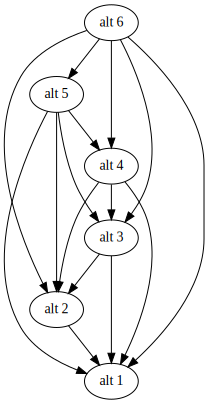

In [3]:
# testing graph_visualization
%autoreload 2

import graph_visualize as gv
i = 90
print(data.votes[i])
print(data.pairs[i])
gv.vec_to_graph(data.pairs[i])
nums_graph = gv.vote_to_graph([6,5,4,3,2,1])
nums_graph

#### Shape of the data

In [4]:
# InteractiveShell.ast_node_interactivity = "last_expr'"
num_votes = len(data)
num_features = len(data.pairs[-1])
num_votes, num_features
print(data_loader)
print(data_loader.dataset[0])

tensor([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
        -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,
         0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,
         0.,  0., -1.,  0., -1.,  0.,  1.])


## Networks

In [5]:
'''
Originally was N -- 1024 -- 512 -- 256 -- 1
'''
N = num_features
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = N
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(N, N),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(N, N),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(N, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden1(x)
        x = self.hidden1(x)
        x = self.out(x)
        return x
    
# def matrix_to_vectors(images):
#     return images.view(images.size(0), 784)

# def vectors_to_images(vectors):
#     return vectors.view(vectors.size(0), 1, 28, 28)
;

''

In [6]:
'''
original architecture was in -- 256 -- 512 -- 1024 -- out
         new architecture is -- in  -- in  -- in   -- out
'''
N = num_features

class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        # hidden layer size
        h = 100
        n_out = N
        
        self.first = nn.Sequential(
            nn.Linear(n_features, h),
            nn.LeakyReLU(0.2)
        )
        self.hidden0 = nn.Sequential(
            nn.Linear(h,2*h),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(2*h, 4*h),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(            
            nn.Linear(4*h, 8*h),
            nn.LeakyReLU(0.2)
        )
        self.hidden3 = nn.Sequential(            
            nn.Linear(8*h, 8*h),
            nn.LeakyReLU(0.2)
        )
        self.hidden4 = nn.Sequential(            
            nn.Linear(8*h, 4*h),
            nn.LeakyReLU(0.2)
        )
        self.hidden5 = nn.Sequential(            
            nn.Linear(4*h, 2*h),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            nn.Linear(2*h, N),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.first(x)
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.hidden3(x)
        x = self.hidden4(x)
        x = self.hidden5(x)
        x = self.out(x)
        
        return x
    
# Noise
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n
;

''

## Send networks to GPU if available

In [7]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    print('GPU available')
    discriminator.cuda()
    generator.cuda()
    ;

GPU available


## Optimization

In [8]:
# Optimizers
# for soi_07_01 these values work best around .0002 and .0001
# for soi_01_03 these values work best around .00004 and .00002
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001)

# Loss function
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1


## Training

In [9]:
'''
The author of this blog post
https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9
suggest using real=0 and fake=1 for improvbed 'gradient flow in the early generations'
'''

def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [10]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

### Generate Samples for Testing

In [11]:
num_test_samples = 5
test_noise = [noise(num_test_samples) for i in range(num_test_samples)]
# test_noise

### Start training

In [12]:
%%time
# Number of epochs
num_epochs = 1


logger = Logger(model_name='PrefGAN', data_name='soi_01_03')
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
print('Logging in graph_logs//{}'.format(timestr))
g_display = None

test_vote_logs = [[] for i in test_noise]



for epoch in range(num_epochs):
    for n_batch, real_batch in enumerate(data_loader):

        # 1. Train Discriminator
        real_data = Variable(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
       
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        
        
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress
        if (n_batch) % 10 == 0 or num_batches - n_batch <= 10:
            display.clear_output(True)
            # Display Graph
            for i, noise_vector in enumerate(test_noise):
                test_vote = generator(noise_vector).data.cpu()[0]
                
                test_vote_logs[i].append(test_vote)
                
#                 g_display = gv.vec_to_graph(test_vote)
#                 g_display.save('epoch{}batch{}graph{}'.format(epoch,n_batch,i),'../graph_logs/{}'.format(timestr))
#                 # g_display.render('../graph_logs/{}/epoch{}batch{}graph{}'.format(timestr,epoch,n_batch,i))
            
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
            

Epoch: [0/1], Batch Num: [3204/3205]
Discriminator Loss: 0.0002, Generator Loss: 10.4371
D(x): 0.0000, D(G(z)): 0.9998
Wall time: 1min 38s


In [13]:
len(test_vote_logs)

5

In [14]:
# torch.save(test_vote_logs,'test_votes_big')

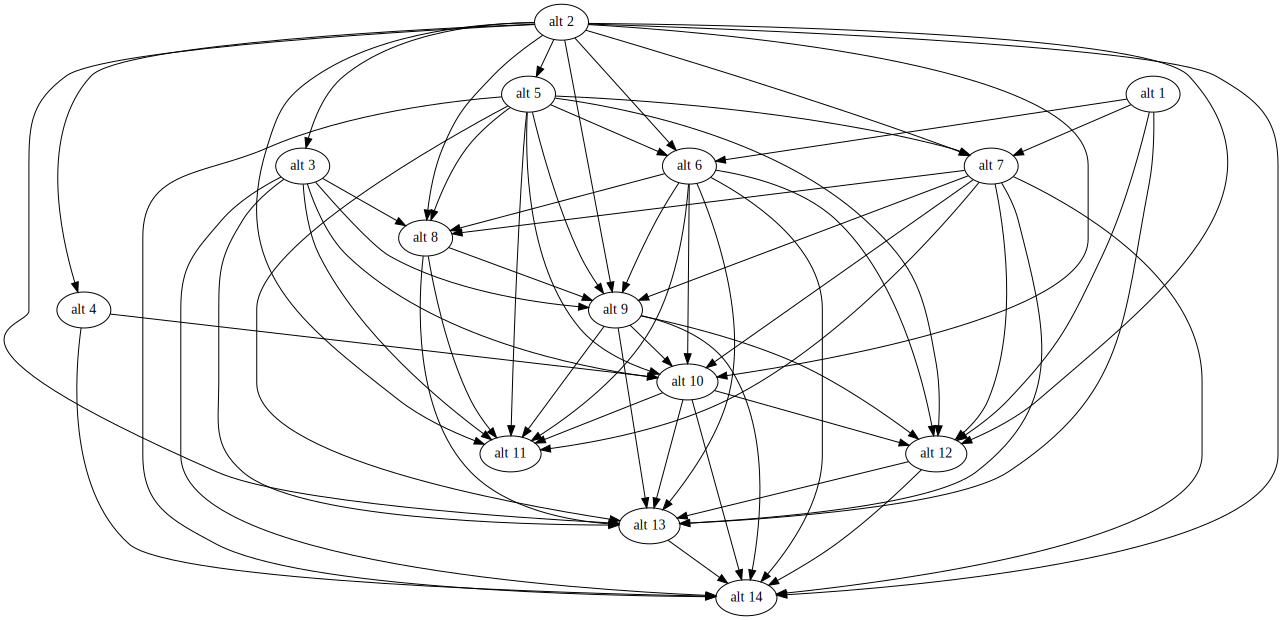

In [15]:
vote0 = test_vote_logs[0][-1]
vote1 = test_vote_logs[1][-1]
vote2 = test_vote_logs[2][-1]
vote3 = test_vote_logs[3][-1]
vote4 = test_vote_logs[4][-1]
gv.vec_to_graph(vote0)

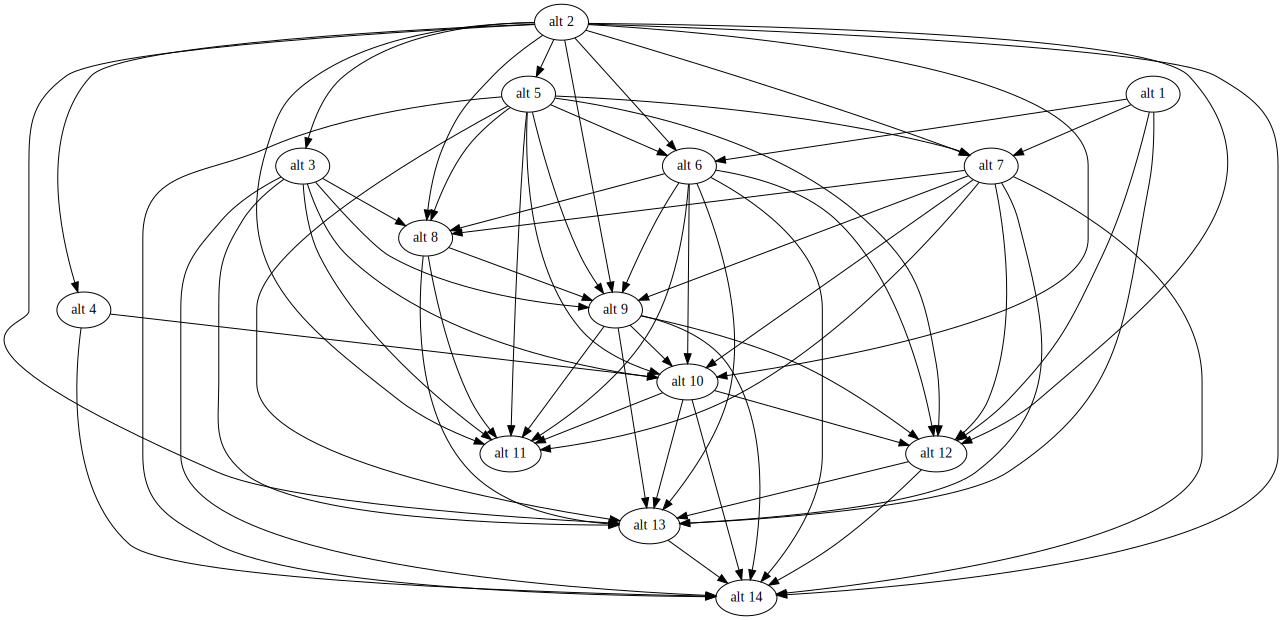

In [16]:
gv.vec_to_graph(vote1)

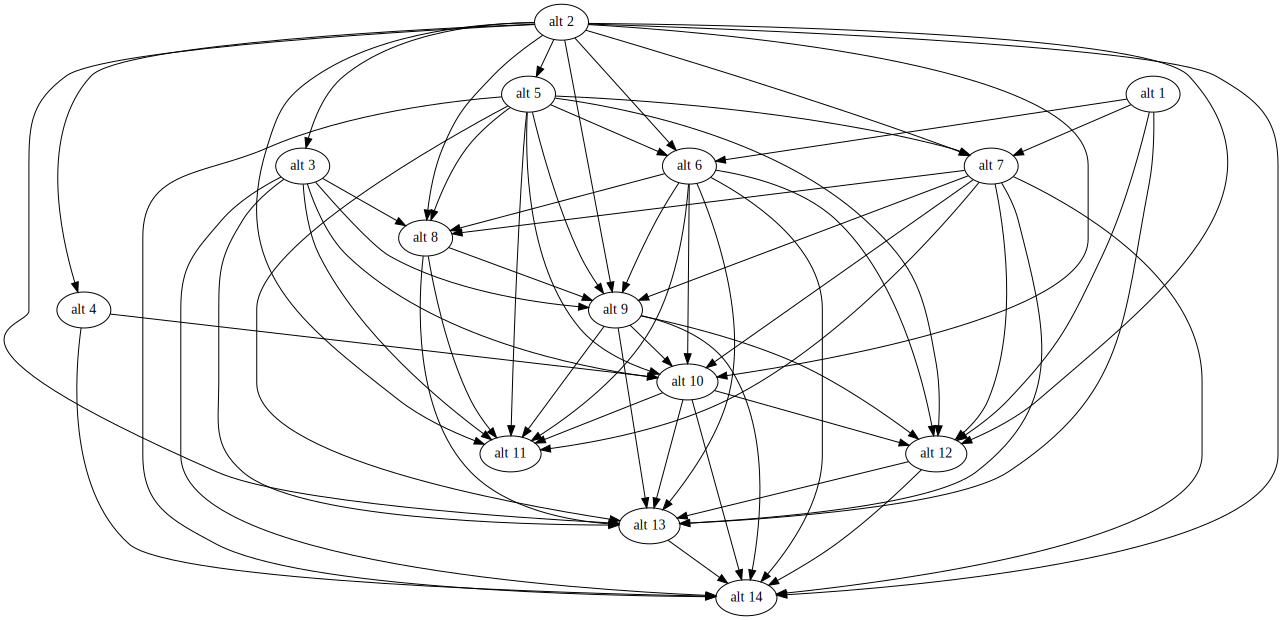

In [17]:
gv.vec_to_graph(vote2)

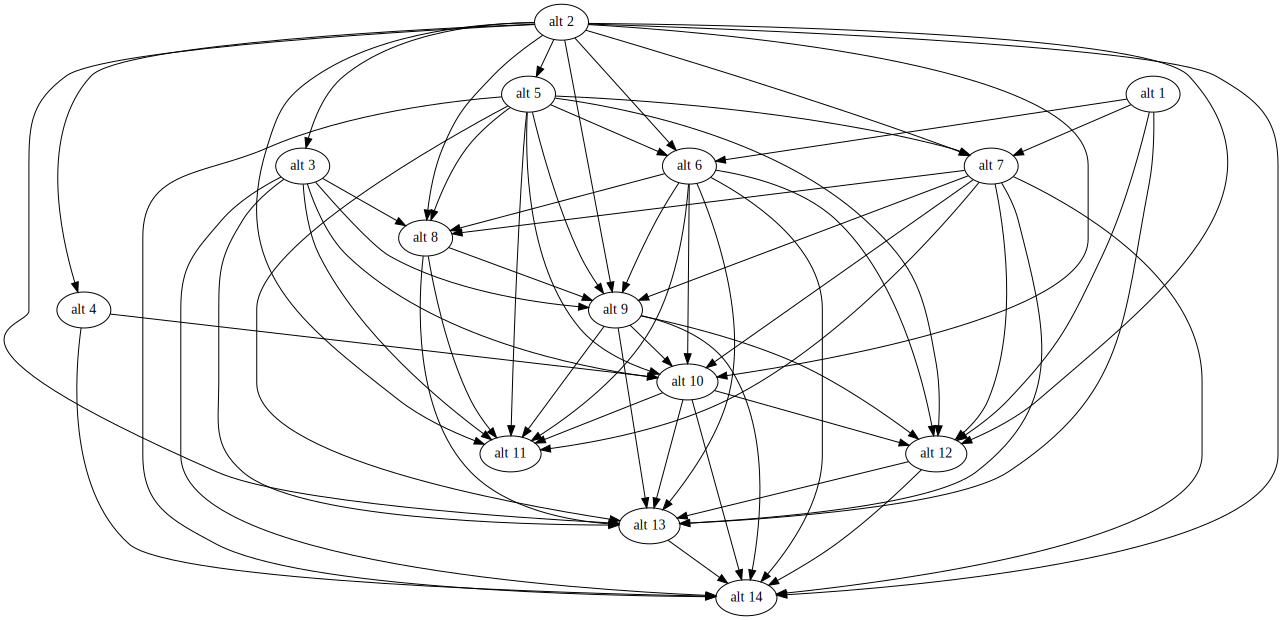

In [18]:
gv.vec_to_graph(vote3)

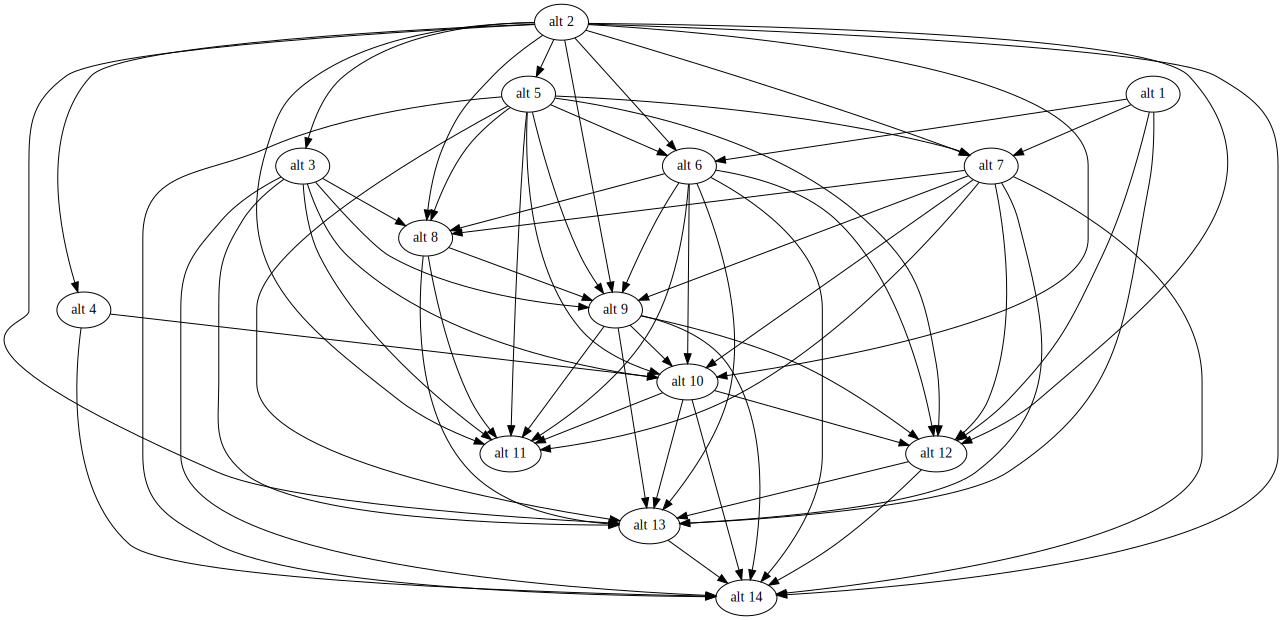

In [19]:
gv.vec_to_graph(vote4)

In [20]:
test_vote_logs[0];

In [21]:
# def pairwise_matrix(vote):
#     n = len(vote)
#     occurance_matrix = np.full(shape = (n,n), dtype = int, fill_value = 0)
    
#     for i, v in enumerate(vote):
#         if v == 0:
#             continue
#         # list of alts that the current alt is better than
#         better_than = [i+1 for i in range(n)]
#         before = vote[:i+1]
#         for b in before:
#             better_than.remove(b)
#         for p in better_than:
#             occurance_matrix[v-1][p-1] = 1
#             occurance_matrix[p-1][v-1] = -1
#     return occurance_matrix


# # Converts an upper triangular matrix to a vector
# def matrix_to_vec(matrix):
#     vec = []
#     n = len(matrix[0])
#     vec_length = n * (n-1) / 2
#     offset = 1
#     for inner in matrix:
#         vec.extend(inner[offset:])
#         offset += 1
#     return np.array(vec)

# # Creates an upper triangular matrix from a vector
# def vec_to_matrix(vec_):
#     data_type = vec_.dtype
#     vec = list(vec_)
#     m = len(vec)
#     n = math.floor(math.sqrt(2*m))
#     prob_matrix = np.full(shape = (n+1,n+1), dtype = data_type, fill_value = 0)
#     row_offset = 1
#     for row in prob_matrix:
#         for i in range(row_offset,n+1):
#             row[i] = vec.pop(0)
#         row_offset += 1
#     return prob_matrix